In [1]:
import sys
sys.path.append('./../features/')

import utils
import nrrd

from vis_stack import show_stack

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

%matplotlib inline

# Crop to tumor mask

In [3]:
ct_image1, _ = nrrd.read('./../../../data_source/images/ct_nrrd/P038CT.nrrd')
ct_mask1, _ = nrrd.read('./../../../data_source/images/masks_nrrd/P038mask.nrrd')

ct_image2, _ = nrrd.read('./../../../data_source/images/ct_nrrd/P116CT.nrrd')
ct_mask2, _ = nrrd.read('./../../../data_source/images/masks_nrrd/P116mask.nrrd')

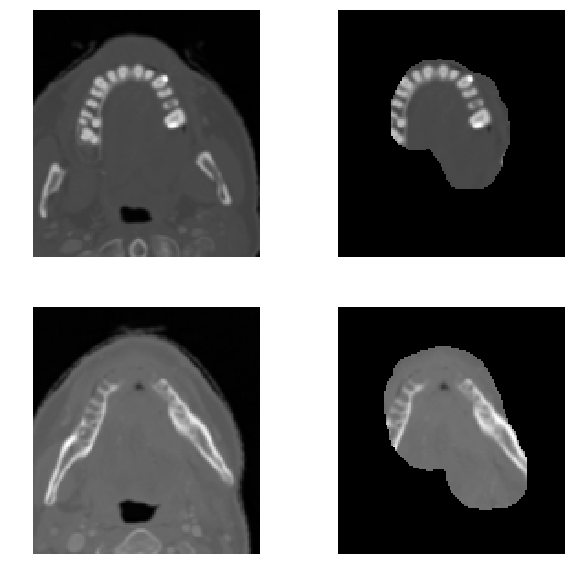

In [4]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
axes[0, 0].imshow(ct_image1[:, :, 89], cmap=plt.cm.gray)
axes[0, 1].imshow(ct_image1[:, :, 89] * ct_mask1[:, :, 89], cmap=plt.cm.gray)

image2_idx = 70
axes[1, 0].imshow(ct_image1[:, :, image2_idx], cmap=plt.cm.gray)
axes[1, 1].imshow(ct_image1[:, :, image2_idx] * ct_mask1[:, :, image2_idx], cmap=plt.cm.gray)

for axis in axes.ravel():
    axis.axis('off')
    
plt.savefig(
    './../../../../ct_tumor_samples.png',
    #'./../../../../ct_cropped_tumor_samples.png',
    bbox_inches='tight',
    transparent=True,
    dpi=600, 
)

In [45]:
pet_image1, _ = nrrd.read('./../../../data_source/images/pet_nrrd/P038PET.nrrd')
pet_mask1, _ = nrrd.read('./../../../data_source/images/masks_nrrd/P038mask.nrrd')

pet_image2, _ = nrrd.read('./../../../data_source/images/pet_nrrd/P253PET.nrrd')
pet_mask2, _ = nrrd.read('./../../../data_source/images/masks_nrrd/P253mask.nrrd')

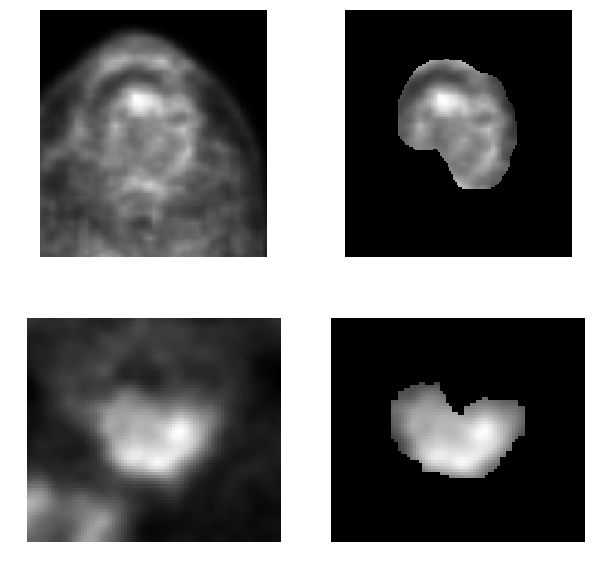

In [6]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
axes[0, 0].imshow(pet_image1[:, :, 89], cmap=plt.cm.gray)
axes[0, 1].imshow(pet_image1[:, :, 89] * pet_mask1[:, :, 89], cmap=plt.cm.gray)

axes[1, 0].imshow(pet_image2[40, :, :], cmap=plt.cm.gray)
axes[1, 1].imshow(pet_image2[40, :, :] * pet_mask2[40, :, :], cmap=plt.cm.gray)

for axis in axes.ravel():
    axis.axis('off')
    
plt.savefig(
    './../../../../pet_tumor_samples.png',
    #'./../../../../pet_cropped_tumor_samples.png',
    bbox_inches='tight',
    transparent=True,
    dpi=600, 
)

# Z-scoring

In [62]:
pet_stdev = np.std(pet_image1) 
ct_stdev = np.std(ct_image1)

pet_mean = np.mean(pet_image1)
ct_mean = np.mean(ct_image1)

pet_std = (pet_image1 - pet_mean) / pet_stdev
ct_std = (ct_image1 - ct_mean) / ct_stdev

np.mean(ct_std), np.std(ct_std), np.mean(pet_std), np.std(pet_std)

(1.3595606403412483e-16, 1.0, -5.133783855156709e-17, 0.9999999999999999)

"    \nplt.savefig(\n    './../../../../z_scoring_pet_ct.png',\n    bbox_inches='tight',\n    transparent=True,\n    dpi=600, \n)"

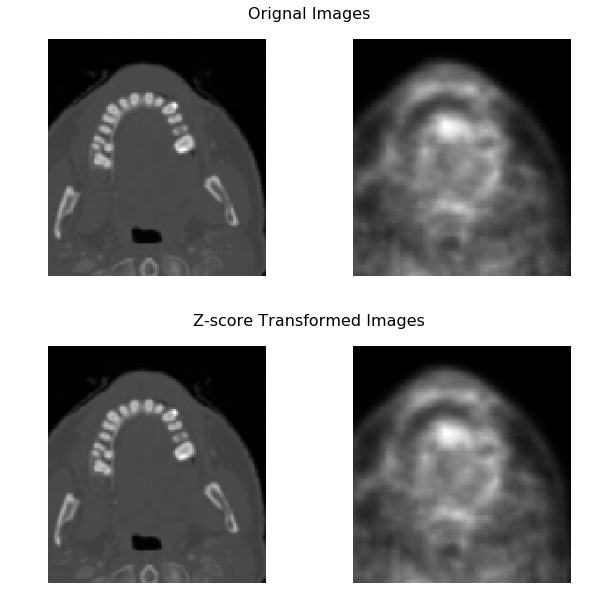

In [79]:
fig, orig_axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))

titles = ['Orignal Images', 'Z-score Transformed Images']
for num, orig_axis in enumerate(orig_axes.ravel()):
    orig_axis.set_title(titles[num], fontsize=16, pad=20)
    orig_axis.axis('off')
    
images = [
    ct_image1[:, :, 89], pet_image1[:, :, 89],
    ct_std[:, :, 89], pet_std[:, :, 89]
]
for num, image in enumerate(images):
    axis = fig.add_subplot(2, 2, num + 1)
    axis.imshow(images[num], cmap=plt.cm.gray)
    axis.axis('off')
    
plt.subplots_adjust(hspace=0.3)

    
"""    
plt.savefig(
    './../../../../z_scoring_pet_ct.png',
    bbox_inches='tight',
    transparent=True,
    dpi=600, 
)"""

# Z-scoring and outlier removal

In [58]:
pet_max_outlier = pet_mean + 3 * pet_stdev
pet_min_outlier = pet_mean - 3 * pet_stdev

ct_max_outlier = ct_mean + 3 * ct_stdev
ct_min_outlier = ct_mean - 3 * ct_stdev

pet_removal = np.copy(pet_std)
pet_removal[pet_std > pet_max_outlier] = 0
pet_removal[pet_std < pet_min_outlier] = 0

ct_removal = np.copy(ct_std)
ct_removal[ct_std > ct_max_outlier] = 0
ct_removal[ct_std < ct_min_outlier] = 0

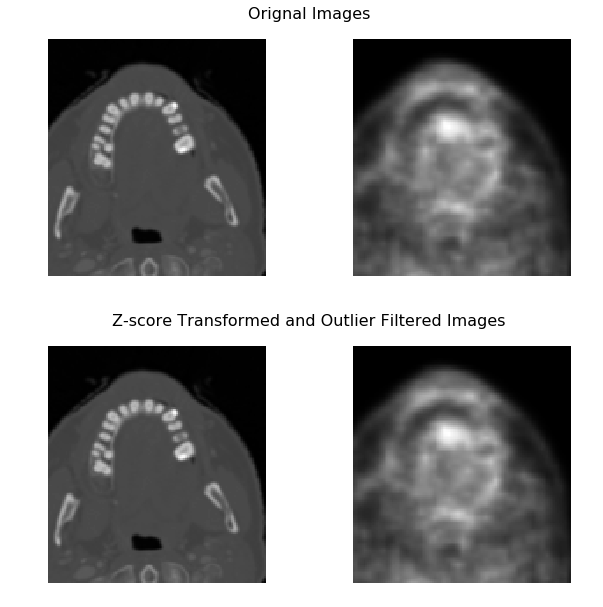

In [78]:
fig, orig_axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))

titles = ['Orignal Images', 'Z-score Transformed and Outlier Filtered Images']
for num, orig_axis in enumerate(orig_axes.ravel()):
    orig_axis.set_title(titles[num], fontsize=16, pad=20)
    orig_axis.axis('off')
    
images = [
    ct_image1[:, :, 89], pet_image1[:, :, 89],
    ct_removal[:, :, 89], pet_removal[:, :, 89]
]
for num, image in enumerate(images):
    axis = fig.add_subplot(2, 2, num + 1)
    axis.imshow(images[num], cmap=plt.cm.gray)
    axis.axis('off')
    
plt.subplots_adjust(hspace=0.3)
   
plt.savefig(
    './../../../../z_scoring_outlier_removal_pet_ct.png',
    bbox_inches='tight',
    transparent=True,
    dpi=600, 
)

# Images

In [ ]:
paths = utils.sample_paths(
    './../../../data_source/images/ct_nrrd/', 
    './../../../data_source/images/masks_nrrd/',
    target_format='nrrd'
)
corrects = 0
for path in paths:
    img_path = path['Image']
    mask_path = path['Mask']
    
    image, _ = nrrd.read(img_path)
    
    image_std = np.std(image)
    image_mean = np.mean(image)
    image_std = (image - image_mean) / image_std

    outlier = 3 * image_std
    if np.any(image_std < outlier - image_mean):
        print('Num CT small outliers: {}'.format(np.sum(image_std < outlier - image_mean)))
        print('of {}'.format(np.size(image)))
    if np.any(image_std > outlier + image_mean):
        print('Num CT large outlies: {}'.format(np.sum(image_std > outlier + image_mean)))
        print('of {}'.format(np.size(image)))
    

In [54]:
paths = utils.sample_paths(
    './../../../data_source/images/pet_nrrd/', 
    './../../../data_source/images/masks_nrrd/',
    target_format='nrrd'
)
corrects = 0
for path in paths:
    img_path = path['Image']
    mask_path = path['Mask']
    
    image, _ = nrrd.read(img_path)
    
    image_std = np.std(image)
    image_mean = np.mean(image)
    image_std = (image - image_mean) / image_std

    outlier = 3 * image_std
    if np.any(image_std < outlier - image_mean):
        print('Num PET small outliers: {}'.format(np.sum(image_std < outlier - image_mean)))
        print('of {}'.format(np.size(image)))
    if np.any(image_std > outlier + image_mean):
        print('Num PET large outlies: {}'.format(np.sum(image_std > outlier + image_mean)))
        print('of {}'.format(np.size(image)))
    

Num small outliers: 22225
of 462808
Num small outliers: 19271
of 326784
Num large outlies: 2240
of 326784
Num small outliers: 33365
of 419020
Num large outlies: 15351
of 419020
Num small outliers: 90658
of 978804
Num large outlies: 52164
of 978804
Num small outliers: 37410
of 373248
Num large outlies: 34185
of 373248
Num small outliers: 61367
of 210304
Num large outlies: 77476
of 210304
Num small outliers: 77705
of 599256
Num large outlies: 117564
of 599256
Num small outliers: 65659
of 777860
Num large outlies: 110923
of 777860
Num small outliers: 31204
of 177444
Num large outlies: 30830
of 177444
Num small outliers: 79007
of 233160
Num large outlies: 75631
of 233160
Num small outliers: 52146
of 312480
Num large outlies: 59875
of 312480
Num small outliers: 76657
of 521472
Num large outlies: 125630
of 521472
Num small outliers: 47862
of 362100
Num large outlies: 72784
of 362100
Num small outliers: 56007
of 438672
Num large outlies: 82761
of 438672
Num small outliers: 60987
of 347060
Num

Num small outliers: 45137
of 491400
Num large outlies: 14159
of 491400
Num small outliers: 74851
of 689920
Num large outlies: 125312
of 689920
Num small outliers: 41509
of 586278
Num large outlies: 5953
of 586278
Num small outliers: 58033
of 566100
Num large outlies: 71395
of 566100
Num small outliers: 56012
of 558450
Num large outlies: 26981
of 558450
Num small outliers: 82663
of 1037880
Num small outliers: 45092
of 569184
Num large outlies: 735
of 569184
Num small outliers: 45701
of 592200
Num large outlies: 8915
of 592200
Num small outliers: 32931
of 331128
Num large outlies: 22531
of 331128
Num small outliers: 44774
of 197780
Num large outlies: 56022
of 197780
Num small outliers: 26758
of 360672
Num large outlies: 5182
of 360672
Num small outliers: 27349
of 304200
Num large outlies: 62677
of 304200
Num small outliers: 57473
of 258888
Num large outlies: 55444
of 258888
Num small outliers: 43013
of 372324
Num large outlies: 6588
of 372324
Num small outliers: 25574
of 233244
Num large

# Isolation Forests

In [2]:
X_raw = pd.read_csv('./../../../data_source/to_analysis/no_filter_concat.csv', index_col=0)
y_raw = pd.read_csv('./../../../data_source/to_analysis/target_dfs.csv', index_col=0)

In [6]:
X_std = StandardScaler().fit_transform(X_raw)
y = np.squeeze(y_raw.values)

/Users/severinlangberg/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/severinlangberg/anaconda/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [8]:
iforest = IsolationForest(
    behaviour='new', 
    max_samples=100,
    random_state=0, 
    contamination='auto'
)
X_od = iforest.fit_predict(X_std)

#clf.fit(X_train)
#y_pred_train = clf.predict(X_train)
#y_pred_test = clf.predict(X_test)
#y_pred_outliers = clf.predict(X_outliers)

In [11]:
X_od

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1, -1,  1,  1,  1,  1,  1,  1, -1,  1, -1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,
        1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1, -1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1, -1,  1,  1, -1,  1, -1,  1,  1,  1,  1,  1,  1, -1,  1,  1,
        1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1])